In [1]:
import Bio.SeqIO as IO
from tqdm.auto import tqdm
import numpy as np 
import pandas as pd

/work/FAC/FBM/DBC/cdessim2/default/sprietob/condaenvs/jlab/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
## Read and sort the data wih the number of proteins and their overall lengths per method/species
stats2=pd.read_csv('/users/sprietob/mywork/Annotation-Orthology/Tables/ProtLengthStats_canonical_4methods_2.csv')
print(stats2)
from pandas.api.types import CategoricalDtype


corr=pd.DataFrame({'Code': ['CIOIN', 'LEPOC', 'DANRE', 'SALTR', 'GADMO', 'ORYLA', 'ECNAU', 'ERCAL', 'XENTR', 'CHPIB', 'CHICK', 'KAKAP', 
                            'TAEGU', 'PODMU', 'ORANA', 'SARHA', 'HUMAN', 'MOUSE', 'FELCA', 'PHOSI'],
                   'Especies': ['C. intestinalis (vase tunicate)', 'L. oculatus (spotted gar)', 'D. rerio (zebrafish)', 
              'S. trutta (brown trout)','G. morhua (Atlantic cod)', 'O. latipes (medaka fish)', 'E. naucrates (live sharksucker)',
              'E. calabaricus (reedfish)', 'X. tropicalis (western clawed frog)', 'C. p. bellii (painted turtle)',
              'G. gallus (chicken)', 'S. habroptila (kakapo)', 'T. guttata (zebra finch)', 
              'P. muralis (wall lizard)','O. anatinus (platypus)', 'S. harrisii (tasmanian devil)', 
              'H. sapiens (human)', 'M. musculus (house mouse)', 'F. catus (domestic cat)', 'P. sinus (vaquita)']})


stats2['Species']= stats2['Species'].map(corr.set_index('Especies')['Code'])

speciesorder = CategoricalDtype(['CIOIN','ERCAL', 'LEPOC', 'DANRE', 'SALTR', 'GADMO', 'ECNAU','ORYLA', 
                                 'XENTR','PODMU', 'CHPIB','CHICK','TAEGU', 'KAKAP',   
                                  'ORANA', 'SARHA', 'PHOSI','FELCA', 'MOUSE','HUMAN'], ordered=True)
stats2['Species'] = stats2['Species'].astype(speciesorder)
stats2=stats2.sort_values('Species')

stats2['Method'] = stats2['Method'].replace('Reference proteomes\n UniProt', 'Reference proteomes UniProt')
methodorder=CategoricalDtype(['Ab-initio','Reference proteomes UniProt', 'NCBI', 'Ensembl'])
stats2['Method']=stats2['Method'].astype(methodorder)
stats2=stats2.sort_values('Method')



                           Method                          Species    count  \
0                       Ab-initio  C. intestinalis (vase tunicate)  13196.0   
1                       Ab-initio        E. calabaricus (reedfish)  78579.0   
2                       Ab-initio        L. oculatus (spotted gar)  36227.0   
3                       Ab-initio             D. rerio (zebrafish)  23288.0   
4                       Ab-initio          S. trutta (brown trout)  51185.0   
..                            ...                              ...      ...   
75  Reference proteomes\n UniProt    S. harrisii (tasmanian devil)  19171.0   
76  Reference proteomes\n UniProt               P. sinus (vaquita)  18892.0   
77  Reference proteomes\n UniProt          F. catus (domestic cat)  19652.0   
78  Reference proteomes\n UniProt        M. musculus (house mouse)  21984.0   
79  Reference proteomes\n UniProt               H. sapiens (human)  20598.0   

          mean         std   min     25%    50%    

In [5]:
pd.set_option('display.max_rows', None)
#stats2

## Count orthologs

In [7]:
## Orthologs counting

path1='/users/sprietob/mywork/Annotationparking/'
metfol =['OMAAugustus20', 'OMARP20', 'OMAtopNCBI20', 'OMAtopEnsembl20']
path2='/Output/PairwiseOrthologs/'

codes=['CIOIN', 'LEPOC', 'DANRE', 'SALTR', 'GADMO', 'ORYLA', 'ECNAU', 'ERCAL', 'XENTR', 'CHPIB', 'CHICK', 'KAKAP', 'TAEGU', 'PODMU', 'ORANA', 'SARHA', 'HUMAN', 'MOUSE', 'FELCA', 'PHOSI']


import os
from collections import defaultdict

# Initialize 'Orthologs' and 'Total_relationships' columns with default values
stats2['Orthologs'] = 0
stats2['Total_relationships'] = 0

relstotals = []
ortotals = []
spe=[]
metodo=[]


for mf in metfol:

    orthologs=defaultdict(lambda: defaultdict(int))
    fns = os.listdir(path1+mf+path2)
    
    for fn in fns:
        z = fn.split('.')[0].split('-')
        if len(z) == 2:
            (sp1, sp2) = z
        else:
            # not pairwise file
            continue
        f=open(path1+mf+path2+fn,'r')
        lines= f.readlines()[4:]
        for l in lines:
            gene1= l.split('\t')[2].split()[0]
            gene2= l.split('\t')[3].split()[0]
            orthologs[sp1][gene1]+=1
            orthologs[sp2][gene2]+=1
        
    for c in codes:
        ortotal=len(orthologs[c])
        relstotal=sum(list(orthologs[c].values()))
        relsavg=relstotal/relstotal

        ortotals.append(ortotal)
        relstotals.append(relstotal)
        spe.append(c)
        metodo.append(mf)
        
ortholognumbers=pd.DataFrame({'Method': metodo, 'Species': spe, 'Orthologues_total': ortotals, 'Relationships_total': relstotals})

The output of the code above:

In [80]:
#ortholognumbers.to_csv('Ortholog_numbers.csv')
ortholognumbers=pd.read_csv('Ortholog_numbers.csv')

In [81]:
ortholognumbers=ortholognumbers.drop(columns='Unnamed: 0')

In [19]:
stats2.groupby('Method')['count'].sum()

Method
Ab-initio                        645378.0
Reference proteomes\n UniProt    428196.0
NCBI                             426843.0
Ensembl                          436713.0
Name: count, dtype: float64

In [10]:
#statsmerge = stats2.merge(ortholognumbers)

In [13]:
#statsmerge

,Species,Method,count,mean,std,min,25%,50%,75%,max,Orthologues_total,Relationships_total,Orthologs_norm,Relats_perOrth,Relats_perGene
0,CIOIN,Ab-initio,13196.0,587.237875,667.740078,36.0,236.0,418.0,717.0,33420.0,6547,100538,0.496135,15.356346,7.618824
1,CIOIN,Reference proteomes UniProt,16680.0,322.028777,347.341120,21.0,144.0,236.0,415.0,21338.0,7452,178245,0.446763,23.919082,10.686151
2,CIOIN,NCBI,13627.0,512.347912,520.487474,35.0,245.0,393.0,616.0,26404.0,8254,247412,0.605709,29.974800,18.156014
3,CIOIN,Ensembl,16671.0,321.240957,346.229801,21.0,144.0,236.0,414.0,21338.0,7467,185286,0.447904,24.813982,11.114270
4,LEPOC,Ab-initio,36227.0,360.272283,416.437873,17.0,137.0,226.0,429.0,22541.0,15308,179561,0.422558,11.729880,4.956552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,FELCA,Reference proteomes UniProt,19652.0,563.930389,554.057233,13.0,264.0,423.0,690.0,27108.0,18385,384469,0.935528,20.912102,19.563861
76,PHOSI,Reference proteomes UniProt,18892.0,536.783242,509.399713,24.0,230.0,405.0,662.0,8798.0,17725,299045,0.938228,16.871368,15.829187
77,PHOSI,NCBI,19069.0,563.881535,583.314773,35.0,259.0,421.0,683.0,34346.0,18288,545257,0.959043,29.815015,28.593896
78,PHOSI,Ensembl,18962.0,522.826179,495.894731,24.0,224.0,395.0,643.0,8798.0,17901,322722,0.944046,18.028155,17.019407


In [19]:
#statsmerge['Orthologs_norm']=statsmerge['Orthologues_total']/statsmerge['count']
#statsmerge['Relats_perOrth']=statsmerge['Relationships_total']/statsmerge['Orthologues_total']
#statsmerge['Relats_perGene']=statsmerge['Relationships_total']/statsmerge['count']

We provide the precomputed table, but you can re generate it by uncommenting the code above

In [8]:
#statsmerge.to_csv('Statsmerge.csv')
statsmerge=pd.read_csv('/users/sprietob/mywork/Annotation-Orthology/Tables/Statsmerge.csv')
statsmerge=statsmerge.drop(columns='Unnamed: 0')

In [9]:
statstolength=pd.DataFrame()
statstolength['Species']=statsmerge['Species']
statstolength['Method']=statsmerge['Method']
statstolength['Prop_orth']=statsmerge['Orthologs_norm']

In [10]:
statstolength['Method'] = statstolength['Method'].replace('Reference proteomes UniProt', 'UniProt')

In [11]:
result=pd.read_csv('/users/sprietob/mywork/Annotationparking/resultmedian.csv')

In [12]:
corr=pd.DataFrame({'Code': ['CIOIN', 'LEPOC', 'DANRE', 'SALTR', 'GADMO', 'ORYLA', 'ECNAU', 'ERCAL', 'XENTR', 'CHPIB', 'CHICK', 'KAKAP', 
                            'TAEGU', 'PODMU', 'ORANA', 'SARHA', 'HUMAN', 'MOUSE', 'FELCA', 'PHOSI'],
                   'Especies': ['C. intestinalis (vase tunicate)', 'L. oculatus (spotted gar)', 'D. rerio (zebrafish)', 
              'S. trutta (brown trout)','G. morhua (Atlantic cod)', 'O. latipes (medaka fish)', 'E. naucrates (live sharksucker)',
              'E. calabaricus (reedfish)', 'X. tropicalis (western clawed frog)', 'C. p. bellii (painted turtle)',
              'G. gallus (chicken)', 'S. habroptila (kakapo)', 'T. guttata (zebra finch)', 
              'P. muralis (wall lizard)','O. anatinus (platypus)', 'S. harrisii (tasmanian devil)', 
              'H. sapiens (human)', 'M. musculus (house mouse)', 'F. catus (domestic cat)', 'P. sinus (vaquita)']})

In [13]:
statstolength['Species']= statstolength['Species'].map(corr.set_index('Code')['Especies'])

In [14]:
merged_df = pd.merge(statstolength, result, on=['Method', 'Species'])

In [16]:
import scipy

In [17]:
corr = scipy.stats.pearsonr(x=merged_df['50%'], y=merged_df['Prop_orth'])

In [34]:
corr

PearsonRResult(statistic=0.8851521954282561, pvalue=1.2282609555053772e-27)

In [18]:
stats2.groupby(['Method']).describe()

/tmp/51684228/ipykernel_2177899/2666810420.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats2.groupby(['Method']).describe()


count                                             \
                            count      mean           std      min       25%   
Method                                                                         
Ab-initio                    20.0  32268.90  20717.213252  13196.0  19258.25   
Reference proteomes UniProt  20.0  21409.80   5769.453168  16021.0  18268.75   
NCBI                         20.0  21342.15   5840.170287  13627.0  18638.00   
Ensembl                      20.0  21835.65   6217.895102  16037.0  18110.25   

                                                         mean              \
                                 50%       75%      max count        mean   
Method                                                                      
Ab-initio                    23451.5  36897.50  91991.0  20.0  479.833911   
Reference proteomes UniProt  20881.0  22126.75  43230.0  20.0  541.002647   
NCBI                         20698.5  21962.25  42405.0  20.0  570.418693   
Ensembl                      21420.5  22999.00  43935.0  20.0  523.065398   

                             ... Orthologs      Total_relationships            \
                             ...       75%  max               count mean  std   
Method                       ...                                                
Ab-initio                    ...       0.0  0.0                20.0  0.0  0.0   
Reference proteomes UniProt  ...       0.0  0.0                20.0  0.0  0.0   
NCBI                         ...       0.0  0.0                20.0  0.0  0.0   
Ensembl                      ...       0.0  0.0                20.0  0.0  0.0   

                                                      
                             min  25%  50%  75%  max  
Method                                                
Ab-initio                    0.0  0.0  0.0  0.0  0.0  
Reference proteomes UniProt  0.0  0.0  0.0  0.0  0.0  
NCBI                         0.0  0.0  0.0  0.0  0.0  
Ensembl                      0.0  0.0  0.0  0.0  0.0  

[4 rows x 80 columns]

In [19]:
pd.set_option('display.max_columns', None)
proportionstats=statsmerge.groupby(['Method'])['Orthologs_norm'].describe()
#proportionstats.to_csv('OrthProp_statsbymethod.csv')

In [20]:
from scipy.stats import shapiro, kruskal, bartlett
countdata=stats2['count']

The tests (Willcoxon) for p-values used in this boxplot are bellow

### Figure 2

/tmp/51684228/ipykernel_2177899/3412129908.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.boxplot(data=stats2, x='Method', y='count', palette=BrBGadapted)
/tmp/51684228/ipykernel_2177899/3412129908.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(method_labels)


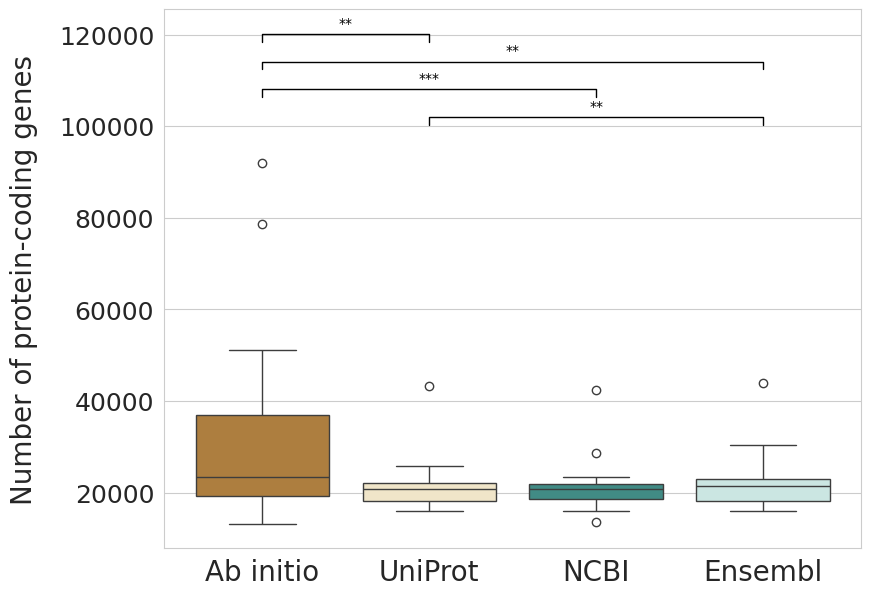

In [21]:
BrBGadapted= ['#BF812D', '#F6E8C3', '#35978F', '#C7EAE5']

sns.set_style("whitegrid")
fig, ax= plt.subplots(figsize=(9,7))
fig = sns.boxplot(data=stats2, x='Method', y='count', palette=BrBGadapted)

# Pre-calculated p-values for pairwise comparisons
p_values = {
    ('Ab-initio', 'Reference proteomes UniProt'): 0.0014,  # Replace with your actual p-values
    ('Ab-initio', 'Ensembl'): 0.0021,
    ('Ab-initio', 'NCBI'): 0.0007,
    ('Reference proteomes UniProt', 'Ensembl'):0.0018
    # Add more pairs and their respective p-values here
}

# Set significance levels
alpha_levels = [0.05, 0.01, 0.001]

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, ((method1, method2), p) in enumerate(p_values.items()):
    # Columns corresponding to the datasets of interest
    x1 = [j for j, method in enumerate(stats2['Method'].unique()) if method == method1][0]
    x2 = [j for j, method in enumerate(stats2['Method'].unique()) if method == method2][0]

    # What level is this bar among the bars above the plot?
    level = len(p_values) - i

    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )

    # Significance level
    sig_symbol = ''
    for alpha_level in alpha_levels:
        if p < alpha_level:
            if alpha_level == 0.001:
                sig_symbol = '***'
            elif alpha_level == 0.01:
                sig_symbol = '**'
            elif alpha_level == 0.05:
                sig_symbol = '*'

    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

    

method_labels = ['Ab initio', 'UniProt', 'NCBI', 'Ensembl']

# Set x-axis tick labels
#ax.set_xticks(range(len(method_labels)))
ax.set_xticklabels(method_labels)

ax.set_ylabel('Number of protein-coding genes', fontsize=20, labelpad=15)
ax.set_xlabel('')
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=20)
#plt.show()
    
#plt.savefig('GenesNumberBoxplotStat.png',bbox_inches='tight', dpi=300)

## Could additionally do Bartlett;s test whatever...

In [22]:
description2=stats2.groupby(['Method']).describe()['count']

/tmp/51684228/ipykernel_2177899/2534875171.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  description2=stats2.groupby(['Method']).describe()['count']


In [13]:
description2

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
Ab-initio,20.0,32268.90,20717.213252,13196.0,19258.25,23451.5,36897.50,91991.0
Ensembl,20.0,21835.65,6217.895102,16037.0,18110.25,21420.5,22999.00,43935.0
NCBI,20.0,21342.15,5840.170287,13627.0,18638.00,20698.5,21962.25,42405.0
Reference proteomes UniProt,20.0,21409.80,5769.453168,16021.0,18268.75,20881.0,22126.75,43230.0


In [51]:
#description2.to_csv("NumberofGenes_stats.csv")

Table for checking normality of difference between groups (paired t-test or willcoxon?)

In [23]:
abin=stats2[stats2["Method"]=='Ab-initio']
refp=stats2[stats2["Method"]=='Reference proteomes UniProt']
ncbi=stats2[stats2["Method"]=='NCBI']
ensembl=stats2[stats2["Method"]=='Ensembl']

abinc=list(abin['count'])
refpc=list(refp['count'])
ncbic=list(ncbi['count'])
ensemblc=list(ensembl['count'])

d = {'Species': abin['Species'], 'Ab-initio': abinc, 'RP-UP': refpc, 'Ensembl': ensemblc, 'NCBI': ncbic}
df= pd.DataFrame(data=d)
df['Ab-RP']= df['Ab-initio']- df['RP-UP']
df['Ab-Ens']= df['Ab-initio'] - df['Ensembl']
df['Ab-NCBI']=df['Ab-initio'] - df['NCBI']
df['RP-Ens']=df['RP-UP'] -df['Ensembl']
df['RP-NCBI']=df['RP-UP']- df['NCBI']
df['Ens-NCBI']=df['Ensembl']- df['NCBI']
df

,Species,Ab-initio,RP-UP,Ensembl,NCBI,Ab-RP,Ab-Ens,Ab-NCBI,RP-Ens,RP-NCBI,Ens-NCBI
0,CIOIN,13196.0,21164.0,22867.0,18200.0,-7968.0,-9671.0,-5004.0,-1703.0,2964.0,4667.0
12,TAEGU,16880.0,16021.0,16671.0,19748.0,859.0,209.0,-2868.0,-650.0,-3727.0,-3077.0
4,SALTR,51185.0,16489.0,23395.0,28638.0,34696.0,27790.0,22547.0,-6906.0,-12149.0,-5243.0
13,KAKAP,17022.0,22099.0,22329.0,18784.0,-5077.0,-5307.0,-1762.0,-230.0,3315.0,3545.0
10,CHPIB,91991.0,17390.0,19588.0,22180.0,74601.0,72403.0,69811.0,-2198.0,-4790.0,-2592.0
14,ORANA,19661.0,19171.0,22107.0,16060.0,490.0,-2446.0,3601.0,-2936.0,3111.0,6047.0
3,DANRE,23288.0,18892.0,18341.0,19966.0,4396.0,4947.0,3322.0,551.0,-1074.0,-1625.0
9,PODMU,34673.0,19652.0,19213.0,17438.0,15021.0,15460.0,17235.0,439.0,2214.0,1775.0
5,GADMO,38909.0,21984.0,17418.0,22071.0,16925.0,21491.0,16838.0,4566.0,-87.0,-4653.0
15,SARHA,16843.0,18112.0,30313.0,19069.0,-1269.0,-13470.0,-2226.0,-12201.0,-957.0,11244.0


In [24]:
pn1=shapiro(df['Ab-RP'])[1]
pn2=shapiro(df['Ab-Ens'])[1]
pn3=shapiro(df['Ab-NCBI'])[1]
pn4=shapiro(df['RP-Ens'])[1]
pn5=shapiro(df['RP-NCBI'])[1]
pn6=shapiro(df['Ens-NCBI'])[1]

None of the differences are normally distributed. However, let's correct for multiple testing

In [25]:
from scipy import stats

In [26]:
pvalues=[pn1, pn2,pn3,pn4,pn5,pn6]
print(pvalues)

[0.00024799867756819966, 0.0013101462626828391, 0.002737939363089046, 0.10747662322638113, 0.012005897713424068, 0.02366949814516898]


In [27]:
stats.false_discovery_control(pvalues,method='bh')

array([0.00148799, 0.00393044, 0.00547588, 0.10747662, 0.01800885,
       0.0284034 ])

## Wilcoxon test for Figure 1

In [28]:
pv1=stats.wilcoxon(df['Ab-RP'], alternative="greater")[1]
st1=stats.wilcoxon(df['Ab-RP'], alternative="greater")[0]
print(stats.wilcoxon(df['Ab-RP'], alternative="greater"))
pv1

WilcoxonResult(statistic=152.0, pvalue=0.0412750244140625)


0.0412750244140625

In [29]:
pv2=stats.wilcoxon(df['Ab-Ens'],alternative="greater")[1]
st2=stats.wilcoxon(df['Ab-Ens'], alternative="greater")[0]
pv2

0.0347900390625

In [30]:
pv3=stats.wilcoxon(df['Ab-NCBI'],alternative="greater")[1]
st3=stats.wilcoxon(df['Ab-NCBI'], alternative="greater")[0]
pv3

0.0085906982421875

In [31]:
pv4=stats.wilcoxon(df['RP-Ens'], alternative="less")[1]
st4=stats.wilcoxon(df['RP-Ens'], alternative="greater")[0]
pv4

0.3780832290649414

In [32]:
pv5=stats.wilcoxon(df['RP-NCBI'], alternative="greater")[1]
st5=stats.wilcoxon(df['RP-NCBI'], alternative="greater")[0]
pv5

0.4061775207519531

In [33]:
pv6=stats.wilcoxon(df['Ens-NCBI'], alternative="greater")[1]
st6=stats.wilcoxon(df['Ens-NCBI'], alternative="greater")[0]
pv6

0.4491586685180664

In [34]:
print(st1,st2,st3,st4,st5,st6)

152.0 154.0 168.0 96.0 112.0 109.0


In [35]:
#bartlett(abinc, refpc, ncbic, ensemblc)

The p-value (2.1271499215093876e-11) from Bartlett’s test is less than α = .05, which means we can reject the null hypothesis that each group has the same variance. 

In [36]:
stats2

,Method,Species,count,mean,std,min,25%,50%,75%,max,Orthologs,Total_relationships
0,Ab-initio,CIOIN,13196.0,587.237875,667.740078,36.0,236.0,418.0,717.0,33420.0,0,0
12,Ab-initio,TAEGU,16880.0,562.503791,621.809784,50.0,227.0,403.0,691.0,36758.0,0,0
4,Ab-initio,SALTR,51185.0,508.474553,560.288128,2.0,182.0,351.0,630.0,29370.0,0,0
13,Ab-initio,KAKAP,17022.0,551.134121,608.594017,49.0,216.0,389.0,672.0,32566.0,0,0
10,Ab-initio,CHPIB,91991.0,293.629268,297.042868,5.0,140.0,211.0,341.0,21620.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29,Ensembl,PODMU,22062.0,532.140332,461.983249,22.0,248.0,414.0,674.0,6598.0,0,0
26,Ensembl,ECNAU,21655.0,525.929116,457.097793,17.0,250.0,407.0,647.0,8621.0,0,0
27,Ensembl,ORYLA,23622.0,544.430108,461.076938,15.0,256.0,421.0,684.0,9615.0,0,0
36,Ensembl,PHOSI,18962.0,522.826179,495.894731,24.0,224.0,395.0,643.0,8798.0,0,0


In [37]:
countdata=abin['count']
stats.shapiro(countdata)

ShapiroResult(statistic=0.7625099721946709, pvalue=0.0002510291885853349)

In [38]:
abin=abin[abin['count']<50000]

In [39]:
abin

,Method,Species,count,mean,std,min,25%,50%,75%,max,Orthologs,Total_relationships
0,Ab-initio,CIOIN,13196.0,587.237875,667.740078,36.0,236.00,418.0,717.0,33420.0,0,0
12,Ab-initio,TAEGU,16880.0,562.503791,621.809784,50.0,227.00,403.0,691.0,36758.0,0,0
13,Ab-initio,KAKAP,17022.0,551.134121,608.594017,49.0,216.00,389.0,672.0,32566.0,0,0
14,Ab-initio,ORANA,19661.0,500.861197,541.002494,10.0,188.00,345.0,613.0,16745.0,0,0
3,Ab-initio,DANRE,23288.0,572.593653,656.834187,1.0,232.00,405.0,705.0,44005.0,0,0
9,Ab-initio,PODMU,34673.0,439.833877,470.676266,20.0,175.00,314.0,536.0,21610.0,0,0
5,Ab-initio,GADMO,38909.0,425.787093,474.394888,7.0,151.00,289.0,526.0,21989.0,0,0
15,Ab-initio,SARHA,16843.0,578.718934,628.424231,60.0,241.00,402.0,711.0,36340.0,0,0
2,Ab-initio,LEPOC,36227.0,360.272283,416.437873,17.0,137.00,226.0,429.0,22541.0,0,0
6,Ab-initio,ECNAU,25404.0,549.279523,601.809214,19.0,194.75,383.0,688.0,23170.0,0,0


### Orthologs numbers

In [40]:
abin=statsmerge[statsmerge["Method"]=='Ab-initio']
refp=statsmerge[statsmerge["Method"]=='Reference proteomes UniProt']
ncbi=statsmerge[statsmerge["Method"]=='NCBI']
ensembl=statsmerge[statsmerge["Method"]=='Ensembl']
abin

,Species,Method,count,mean,std,min,25%,50%,75%,max,Orthologues_total,Relationships_total,Orthologs_norm,Relats_perOrth,Relats_perGene
0,CIOIN,Ab-initio,13196.0,587.237875,667.740078,36.0,236.00,418.0,717.0,33420.0,6547,100538,0.496135,15.356346,7.618824
4,LEPOC,Ab-initio,36227.0,360.272283,416.437873,17.0,137.00,226.0,429.0,22541.0,15308,179561,0.422558,11.729880,4.956552
8,DANRE,Ab-initio,23288.0,572.593653,656.834187,1.0,232.00,405.0,705.0,44005.0,19222,308132,0.825404,16.030174,13.231364
12,SALTR,Ab-initio,51185.0,508.474553,560.288128,2.0,182.00,351.0,630.0,29370.0,35429,463848,0.692175,13.092325,9.062186
17,GADMO,Ab-initio,38909.0,425.787093,474.394888,7.0,151.00,289.0,526.0,21989.0,21783,298865,0.559845,13.720103,7.681128
23,ORYLA,Ab-initio,33024.0,453.040728,544.681967,66.0,157.00,298.0,558.0,33977.0,19967,260107,0.604621,13.026844,7.876302
25,ECNAU,Ab-initio,25404.0,549.279523,601.809214,19.0,194.75,383.0,688.0,23170.0,18970,267270,0.746733,14.089088,10.520784
28,ERCAL,Ab-initio,78579.0,249.338347,257.867127,3.0,114.00,169.0,292.0,16208.0,17056,340778,0.217055,19.979948,4.336757
33,XENTR,Ab-initio,40554.0,442.507052,542.063947,41.0,154.00,303.0,530.0,35366.0,18439,367643,0.454678,19.938337,9.065518
38,CHPIB,Ab-initio,91991.0,293.629268,297.042868,5.0,140.00,211.0,341.0,21620.0,37691,547473,0.409725,14.525298,5.951376


In [41]:
abin=statsmerge[statsmerge["Method"]=='Ab-initio']
refp=statsmerge[statsmerge["Method"]=='Reference proteomes UniProt']
ncbi=statsmerge[statsmerge["Method"]=='NCBI']
ensembl=statsmerge[statsmerge["Method"]=='Ensembl']

abinc=list(abin['Orthologs_norm'])
refpc=list(refp['Orthologs_norm'])
ncbic=list(ncbi['Orthologs_norm'])
ensemblc=list(ensembl['Orthologs_norm'])

d = {'Species': abin['Species'], 'Ab-initio': abinc, 'RP-UP': refpc, 'Ensembl': ensemblc, 'NCBI': ncbic}
df= pd.DataFrame(data=d)
df['Ab-RP']= df['Ab-initio']- df['RP-UP']
df['Ab-Ens']= df['Ab-initio'] - df['Ensembl']
df['Ab-NCBI']=df['Ab-initio'] - df['NCBI']
df['RP-Ens']=df['RP-UP'] -df['Ensembl']
df['RP-NCBI']=df['RP-UP']- df['NCBI']
df['Ens-NCBI']=df['Ensembl']- df['NCBI']
df

,Species,Ab-initio,RP-UP,Ensembl,NCBI,Ab-RP,Ab-Ens,Ab-NCBI,RP-Ens,RP-NCBI,Ens-NCBI
0,CIOIN,0.496135,0.446763,0.447904,0.605709,0.049373,0.048232,-0.109574,-0.001141,-0.158947,-0.157806
4,LEPOC,0.422558,0.932154,0.933755,0.922807,-0.509597,-0.511197,-0.500249,-0.001601,0.009348,0.010948
8,DANRE,0.825404,0.902711,0.910896,0.903520,-0.077308,-0.085493,-0.078116,-0.008185,-0.000808,0.007377
12,SALTR,0.692175,0.903609,0.917537,0.914963,-0.211433,-0.225362,-0.222787,-0.013929,-0.011354,0.002574
17,GADMO,0.559845,0.910405,0.925112,0.936981,-0.350560,-0.365267,-0.377136,-0.014707,-0.026576,-0.011869
23,ORYLA,0.604621,0.930601,0.938024,0.960401,-0.325980,-0.333403,-0.355780,-0.007423,-0.029800,-0.022377
25,ECNAU,0.746733,0.954010,0.956407,0.983747,-0.207277,-0.209674,-0.237014,-0.002398,-0.029737,-0.027339
28,ERCAL,0.217055,0.903422,0.908729,0.909739,-0.686366,-0.691673,-0.692683,-0.005307,-0.006317,-0.001010
33,XENTR,0.454678,0.882031,0.908898,0.893247,-0.427353,-0.454220,-0.438569,-0.026867,-0.011216,0.015651
38,CHPIB,0.409725,0.890096,0.900642,0.932954,-0.480372,-0.490917,-0.523229,-0.010546,-0.042858,-0.032312


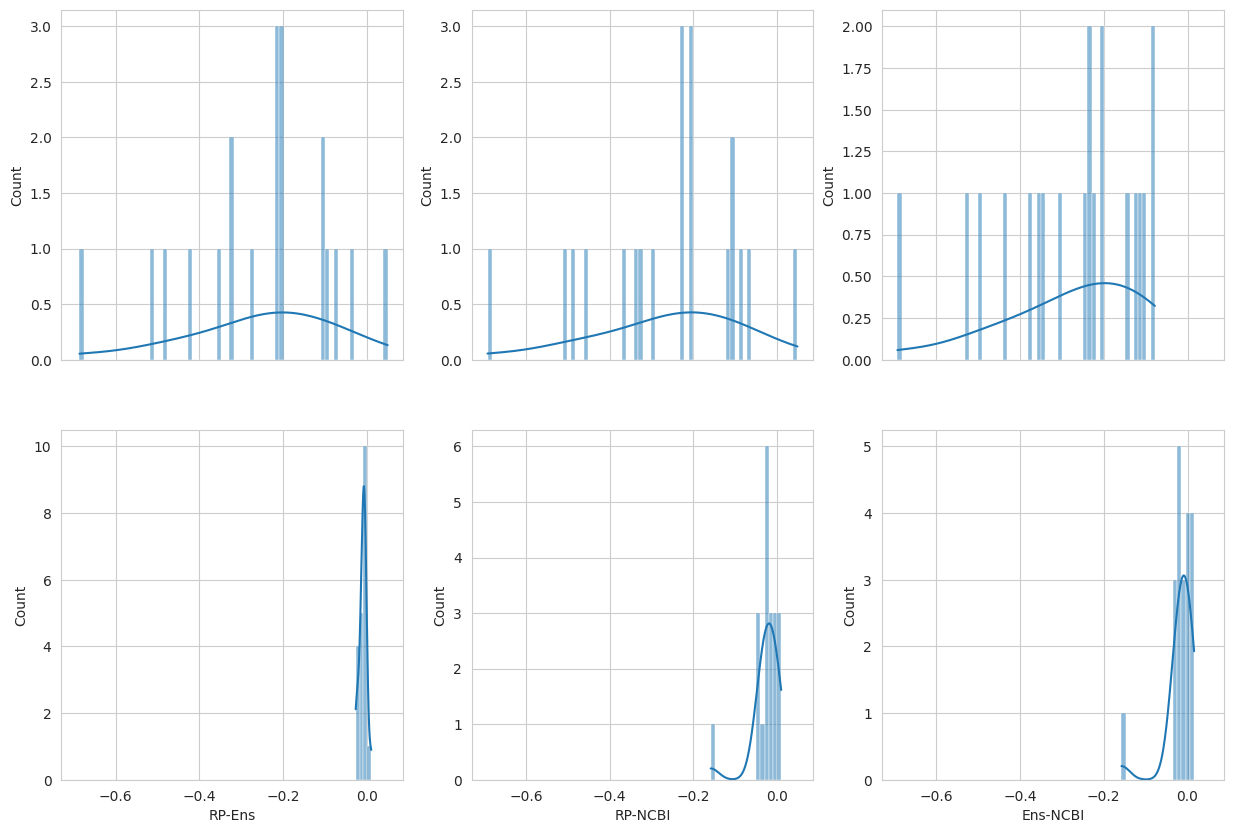

In [42]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2,3, figsize=(15,10), sharex=True)

fig = sns.histplot(data=df, x='Ab-RP', binwidth=0.01, kde=True, ax=ax1)
fig = sns.histplot(data=df, x='Ab-Ens', binwidth=0.01, kde=True, ax=ax2)
fig= sns.histplot(data=df, x='Ab-NCBI', binwidth=0.01, kde=True, ax=ax3)
fig= sns.histplot(data=df, x='RP-Ens', binwidth=0.01, kde=True, ax=ax4)
fig= sns.histplot(data=df, x='RP-NCBI', binwidth=0.01, kde=True, ax=ax5)
fig= sns.histplot(data=df, x='Ens-NCBI', binwidth=0.01, kde=True, ax=ax6)


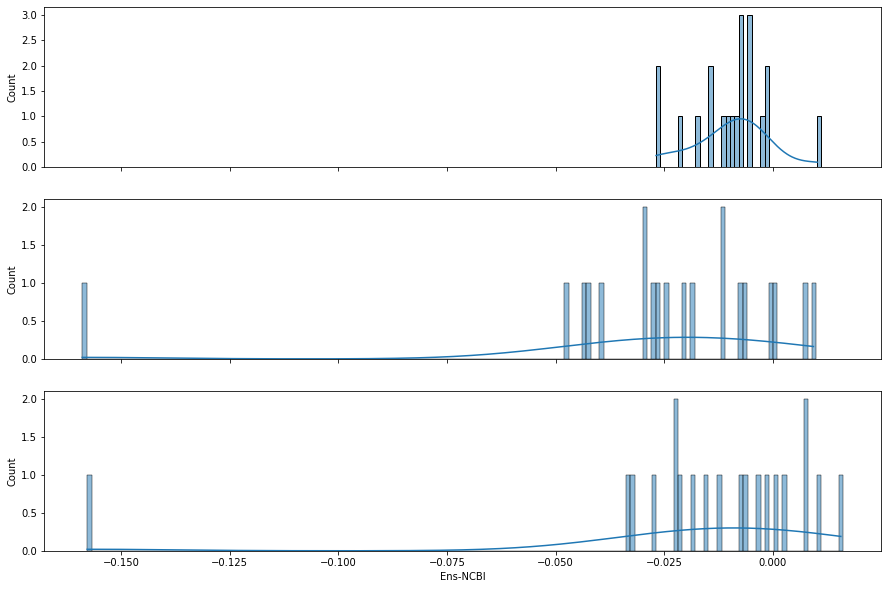

In [25]:
fig, (ax1, ax2, ax3)= plt.subplots(3, figsize=(15,10), sharex=True)

fig= sns.histplot(data=df, x='RP-Ens', binwidth=0.001, kde=True, ax=ax1)
fig= sns.histplot(data=df, x='RP-NCBI', binwidth=0.001, kde=True, ax=ax2)
fig= sns.histplot(data=df, x='Ens-NCBI', binwidth=0.001, kde=True, ax=ax3)

In [43]:
from scipy import stats
pn1=stats.shapiro(df['Ab-RP'])[1]
pn2=stats.shapiro(df['Ab-Ens'])[1]
pn3=stats.shapiro(df['Ab-NCBI'])[1]
pn4=stats.shapiro(df['RP-Ens'])[1]
pn5=stats.shapiro(df['RP-NCBI'])[1]
pn6=stats.shapiro(df['Ens-NCBI'])[1]
pvalues=[pn1, pn2,pn3,pn4,pn5,pn6]

print(pvalues)

[0.49195994795648984, 0.504189970341902, 0.1052705327676633, 0.42551224982403424, 3.779369659394724e-05, 5.1697148369993336e-06]


In [44]:
pv1=stats.wilcoxon(df['Ab-RP'], alternative= "less")[1]
pv2=stats.wilcoxon(df['Ab-Ens'], alternative="less")[1]
pv3=stats.wilcoxon(df['Ab-NCBI'], alternative="less")[1]
pv4=stats.wilcoxon(df['RP-Ens'], alternative="less")[1]
pv5=stats.wilcoxon(df['RP-NCBI'], alternative="less")[1]
pv6=stats.wilcoxon(df['Ens-NCBI'], alternative="less")[1]

st1=stats.wilcoxon(df['Ab-RP'], alternative="less")[0]
st2=stats.wilcoxon(df['Ab-Ens'], alternative="less")[0]
st3=stats.wilcoxon(df['Ab-NCBI'], alternative="less")[0]
st4=stats.wilcoxon(df['RP-Ens'], alternative="less")[0]
st5=stats.wilcoxon(df['RP-NCBI'], alternative="less")[0]
st6=stats.wilcoxon(df['Ens-NCBI'], alternative="less")[0]

pvals=[pv1, pv2,pv3,pv4,pv5,pv6]
sts=[st1,st2,st3,st4,st5,st6]
print(pvals)
print(sts)

[2.86102294921875e-06, 1.9073486328125e-06, 9.5367431640625e-07, 6.67572021484375e-05, 6.67572021484375e-05, 0.006808280944824219]
[2.0, 1.0, 0.0, 12.0, 12.0, 40.0]


### Figure 3

/tmp/51684228/ipykernel_2177899/4293615415.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fig = sns.boxplot(data=statsmerge, x='Method', y='Orthologs_norm', palette=BrBGadapted)
/tmp/51684228/ipykernel_2177899/4293615415.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(method_labels)


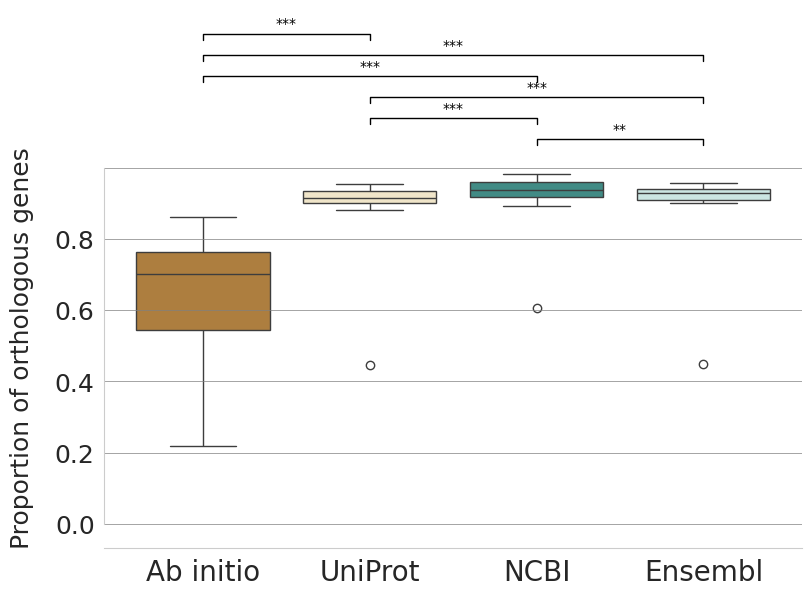

In [88]:
BrBGadapted= ['#BF812D', '#F6E8C3', '#35978F', '#C7EAE5']


fig, ax= plt.subplots(figsize=(9,7))
fig = sns.boxplot(data=statsmerge, x='Method', y='Orthologs_norm', palette=BrBGadapted)

# Pre-calculated p-values for pairwise comparisons
p_values = {
    ('Ab-initio', 'Reference proteomes UniProt'): 0.000,  # Replace with your actual p-values
    ('Ab-initio', 'Ensembl'): 0.000,
    ('Ab-initio', 'NCBI'): 0.000,
    ('Reference proteomes UniProt', 'Ensembl'):0.000,
    ('Reference proteomes UniProt', 'NCBI'): 0.000,
    ('Ensembl', 'NCBI'): 0.007
    
    # Add more pairs and their respective p-values here
}

# Set significance levels
alpha_levels = [0.05, 0.01, 0.001]

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, ((method1, method2), p) in enumerate(p_values.items()):
    # Columns corresponding to the datasets of interest
    x1 = [j for j, method in enumerate(stats2['Method'].unique()) if method == method1][0]
    x2 = [j for j, method in enumerate(stats2['Method'].unique()) if method == method2][0]

    # What level is this bar among the bars above the plot?
    level = len(p_values) - i

    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )

    # Significance level
    sig_symbol = ''
    for alpha_level in alpha_levels:
        if p < alpha_level:
            if alpha_level == 0.001:
                sig_symbol = '***'
            elif alpha_level == 0.01:
                sig_symbol = '**'
            elif alpha_level == 0.05:
                sig_symbol = '*'

    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')


method_labels = ['Ab initio', 'UniProt', 'NCBI', 'Ensembl']

# Set x-axis tick labels
ax.set_xticklabels(method_labels)

ax.set_ylabel('Proportion of orthologous genes', fontsize=18, labelpad=15, loc= 'bottom')
ax.set_xlabel('')
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=20)

# Hide y-tick labels above 1 (but keep 1.0 visible)
for label in ax.get_yticklabels():
    if float(label.get_text()) > 1:
        label.set_visible(False)


# Turn off grid lines globally
ax.grid(False)

# Turn on grid lines only for values <= 1
for ytick in ax.get_yticks():
    if 0 <= ytick <= 1:  # Only show grid lines for values between 0 and 1
        ax.axhline(y=ytick, color='gray', linestyle='-', linewidth=0.5)
#sns.set_style("whitegrid")
# Remove the y-axis line above 1 (hides part of the spine)
ax.spines['left'].set_bounds(0, 1)

sns.despine()
plt.savefig('/users/sprietob/mywork/AnnotationExtras/Orthologs_byMethod_stats.svg',bbox_inches='tight', dpi=300)
#plt.show()
    

In [54]:
import statistics
from scipy import stats

def pos(lst):
    return [x for x in lst if x > 0] or None
def neg(lst):
    return[x for x in lst if x<0] or None

positivediff= statistics.mean(pos(list(NCBIdiff['NCBI over Ensembl'])+ list(NCBIdiff['NCBI over UP'])))
positivediffsem=stats.sem(pos(list(NCBIdiff['NCBI over Ensembl'])+ list(NCBIdiff['NCBI over UP'])))
negativediff= statistics.mean(neg(list(NCBIdiff['NCBI over Ensembl'])+ list(NCBIdiff['NCBI over UP'])))
negativediffsem=stats.sem(neg(list(NCBIdiff['NCBI over Ensembl'])+ list(NCBIdiff['NCBI over UP'])))

print(positivediff)
print(positivediffsem)

print(negativediff)
print(negativediffsem)

0.029789242645473238
0.006574533504614605
-0.006885884017786287
0.0016748204423209236


In [96]:
description3=statsmerge.groupby(['Method']).describe()['Orthologues_total']

In [56]:
description3

,count,mean,std,min,25%,50%,75%,max
Method,,,,,,,,
Ab-initio,20.0,18297.80,7048.106223,6547.0,14560.75,16994.5,19408.25,37691.0
Ensembl,20.0,19867.35,6245.523578,7467.0,16925.00,19555.5,21486.25,40312.0
NCBI,20.0,19755.40,5610.432833,8254.0,17422.50,19356.5,20670.50,38799.0
Reference proteomes UniProt,20.0,19262.20,5760.695788,7452.0,16940.50,19165.0,20616.50,39063.0


In [117]:
bartlett(list(abin['Orthologs_norm']), list(refp['Orthologs_norm']), 
         list(ncbi['Orthologs_norm']), list(ensembl['Orthologs_norm']))

BartlettResult(statistic=12.689875202657227, pvalue=0.005357604074879432)

## Figure 1

### Tree

In [38]:
import toytree
import toyplot

In [44]:
tre2=toytree.tree('species20tree.nwk')
tre3=toytree.tree('cladogram20species.nwk')

In [45]:
newlabels=['Homo sapiens','Mus musculus','Felis catus','Phocoena sinus','Sarcophilus harrisii ', 'Ornithorhynchus anatinus',
 'Strigops habroptila', 'Taeniopygia guttata','Gallus gallus','Chrysemys picta bellii','Podarcis muralis',
 'Xenopus tropicalis','Oryzias latipes','Echeneis naucrates','Gadus morhua', 'Salmo trutta','Danio rerio',
 'Lepisosteus oculatus', 'Erpetoichthys calabaricus','Ciona intestinalis']

In [46]:
tip_labels_estilo={
        "fill": "#262626",
        "font-size": "14px",
        "-toyplot-anchor-shift": "10px",
    }

In [47]:
# make the canvas and axes
canvas = toyplot.Canvas(width=1100, height=400)
axes = canvas.cartesian()
axes.show = False

# draw a rectangle (x1, x2, y1, y2)
axes.rectangle(
    -5.5, 0.35, -4.5, 21,
    opacity=0.25,
    color="darkred",
)

#draw a rectangle (x1, x2, y1, y2)
axes.rectangle(
    -8.5, -5.6, -2.5, 21,
    opacity=0.25,
    color="#1A8828",
)

axes.rectangle(
    -16.5, -11.5, -4.5, 21,
    opacity=0.25,
    color=toytree.colors[2],
)


# add tree to the axes
tre3.draw(layout='u',axes=axes,tip_labels=newlabels, tip_labels_style=tip_labels_estilo);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1100.0px" height="400.0px" viewBox="0 0 1100.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t770c715cd2fc4d908ad2045d602a0c5d"> Homo sapiens Mus musculus Felis catus Phocoena sinus Sarcophilus harrisii Ornithorhynchus anatinus Strigops habroptila Taeniopygia guttata Gallus gallus Chrysemys picta bellii Podarcis muralis Xenopus tropicalis Oryzias latipes Echeneis naucrates Gadus morhua Salmo trutta Danio rerio Lepisosteus oculatus Erpetoichthys calabaricus Ciona intestinalis

In [ ]:
import toyplot.svg
toyplot.svg.render(canvas, "tree-plot2-noname.svg")

#### Tree without labels for Figure 6

In [ ]:
# make the canvas and axes
canvas = toyplot.Canvas(width=700, height=180)
axes = canvas.cartesian()
axes.show = False

# draw a rectangle (x1, x2, y1, y2) - RED
axes.rectangle(
    -5.5, 0.35, -4.5, 7,
    opacity=0.25,
    color="darkred",
)

#draw a rectangle (x1, x2, y1, y2) - GREEN
axes.rectangle(
    -8.5, -5.6, -2.5, 7,
    opacity=0.25,
    color="#1A8828",
)

#BLUE
axes.rectangle(
    -16.5, -11.5, -4.5, 7,
    opacity=0.25,
    color=toytree.colors[2],
)
# add tree to the axes
tre3.draw(layout='u',axes=axes, tip_labels=False);

## Merged plots

In [105]:
especies=tre2.get_tip_labels()
especies.reverse()
especies

['CIOIN',
 'ERCAL',
 'LEPOC',
 'DANRE',
 'SALTR',
 'GADMO',
 'ECNAU',
 'ORYLA',
 'XENTR',
 'PODMU',
 'CHPIB',
 'CHICK',
 'TAEGU',
 'KAKAP',
 'ORANA',
 'SARHA',
 'PHOSI',
 'FELCA',
 'MOUSE',
 'HUMAN']

In [106]:
corrm=pd.DataFrame({'Me': ['Ab-initio', 'Reference proteomes UniProt', 'Ensembl', 'NCBI'],
                   'Method': ['Ab-initio', 'UniProt', 'Ensembl', 'NCBI']})

In [107]:
mes=['Ab-initio', 'Reference proteomes UniProt', 'Ensembl', 'NCBI']
methodsorder = CategoricalDtype(mes, ordered=True)
statsmerge['Method'] = statsmerge['Method'].astype(methodsorder)
statsmerge['Method']= statsmerge['Method'].map(corrm.set_index('Me')['Method'])

In [12]:
mypaleta=['#BF812D', '#E2D7A1',  '#A8DFD4', '#35978F'] #darker colours

In [13]:
stats2['Method'] = stats2['Method'].replace('Reference proteomes UniProt', 'UniProt')

### Figure 1

([], [])

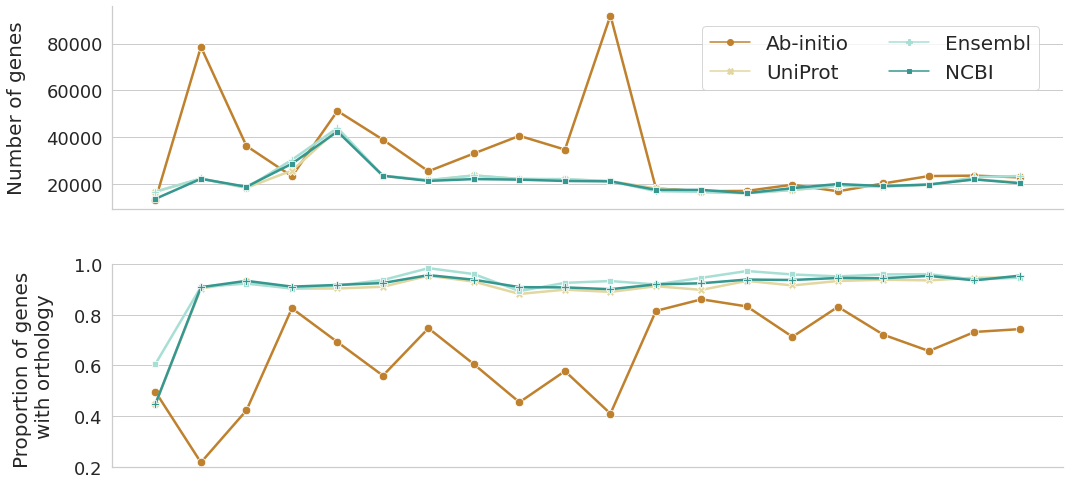

In [14]:
sns.set_context("notebook")
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16,8))

fig=sns.lineplot(data=stats2,x="Species", y="count", hue="Method",palette=mypaleta,hue_order=['Ab-initio', 'UniProt', 'Ensembl', 'NCBI'],
                  style="Method",linewidth=2.5, markersize=8.5, markers=True, dashes=False, ax=ax1)

fig=sns.lineplot(data=statsmerge,x="Species", y="Orthologs_norm", hue="Method",palette=mypaleta,
                  style="Method",linewidth=2.5, markersize=8.5, markers=True, dashes=False, ax=ax2)

ax1.set(xlabel=None)
ax2.set(xlabel=None)
ax2.get_legend().remove()
ax1.set_ylabel('Number of genes', labelpad=20, size=20)
#ax1.set(ylabel='Number of genes')

ax2.set_ylabel('Proportion of genes \nwith orthology', labelpad=20, size=20)
ax2.set_ylim([0.2,1.0])
ax1.legend(bbox_to_anchor=(0.61, 0.95), ncol=2, fontsize=20)
#sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1.3))
sns.despine()
#plt.legend(bbox_to_anchor=(0.05, 0.85), loc='upper left', title= "Parameters species")

ax1.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)

plt.tight_layout(pad=4)
plt.xticks([],)
#plt.show()
#plt.savefig('TwoPlots2-lineplots.png',bbox_inches='tight', dpi=300)

## Tree extras

In [21]:
toyplot.html.render(canvas, "/tmp/tree-plot2.html")

In [49]:
tre3.draw(
    layout='u',
    width=980,
    height=250,
);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="980.0px" height="250.0px" viewBox="0 0 980.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb9c3224c76674f38aec3d930048b840b"> HUMAN MOUSE FELCA PHOSI SARHA ORANA KAKAP TAEGU CHICK CHPIB PODMU XENTR ORYLA ECNAU GADMO SALTR DANRE LEPOC ERCAL CIOIN

In [50]:
tre2.draw(layout="u",tip_labels_align=True);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="360.0px" height="275.0px" viewBox="0 0 360.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tadcea9cac98c449088fea1031d8633d5"> HUMAN MOUSE FELCA PHOSI SARHA ORANA KAKAP TAEGU CHICK CHPIB PODMU XENTR ORYLA ECNAU GADMO SALTR DANRE LEPOC ERCAL CIOIN

In [ ]:
tre3.draw(ts='s', layout='u'); #With 's' ts --> cladogram, only found after adapting branch distances in tre3 (cladogram20species.nwk)

In [40]:
tre2.root(names='CIOIN')

In [44]:
styledict={"tip_labels_align": True, "layout": "u"}

In [66]:
tre2.features

{'dist', 'height', 'idx', 'name', 'support'}